In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
df0 = pd.read_csv('prices_round_2_day_0.csv', delimiter = ';') 
df1 = pd.read_csv('prices_round_2_day_-1.csv', delimiter = ';') 
df2 = pd.read_csv('prices_round_2_day_1.csv', delimiter = ';') 

In [43]:
X_COLUMNS = ['IMPORT_TARIFF', 'EXPORT_TARIFF','ProductionChange', 'TRANSPORT_FEES']
Y_COLUMN = 'OrchidPctChg30'

# Transforming dataframe to have our necessary data

In [42]:
def transform_df(df):
    
    df['SUNLIGHT'] /= 365
    
    def calculate_humidity_production_change(H):
        if 60 <= H <= 80:
            return 0
        elif H < 60:
            num_fives = (60 - H) // 5
            return num_fives * -0.02
        else:  # H > 80
            num_fives = (H - 80) // 5
            return num_fives * -0.02
    
    def calculate_sunlight_production_change(s):
        # Round down to the nearest 10 minutes
        hours = int(s)  # Extracts the whole number of hours
        minutes = s * 60  # Converts hours to minutes
        rounded_minutes = (minutes // 10) * 10  # Rounds down to the nearest 10 minutes
        rounded_hours = rounded_minutes / 60  # Converts back to hours
        
        if rounded_hours < 7:
            ten_minute_intervals = (7 - rounded_hours) * 6
            return -0.04 * ten_minute_intervals
        else:
            return 0
    
    def total_production_change(H, s):
        humidity_change = calculate_humidity_production_change(H)
        sunlight_change = calculate_sunlight_production_change(s)
        production_change = humidity_change + sunlight_change
    
        return production_change

    df['ProductionChange'] = df.apply(lambda x: total_production_change(x['HUMIDITY'], x['SUNLIGHT']), axis=1)

    def period_pct_change(series, period):
        return np.log1p(series.pct_change(period)).shift(-period)

    df[f'OrchidPctChg{30}'] = period_pct_change(df['ORCHIDS'], 30)
    df['Orchid_ret'] = np.log1p(df['ORCHIDS'].pct_change())
    return df

# XGBoost

In [38]:
def run_xgboost_regression(df, x_columns, y_column):
    '''
    Returns the XGBoost model itself
    '''
    df = df.dropna()
    X = df[x_columns]
    y = df[y_column]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Initialize the XGBoost regressor
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
    
    # Fit the regressor to the training set
    xg_reg.fit(X_train, y_train)

    return xg_reg

# Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def run_random_forest_regression(df, x_columns, y_column):
    '''
    Returns the Random Forest model itself.
    '''
    df = df.dropna()
    X = df[x_columns]
    y = df[y_column]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest regressor
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)  # default 100 trees
    
    # Fit the regressor to the training set
    rf_reg.fit(X_train, y_train)

    return rf_reg

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

final_coef = []
final_int = 0

# def run_linreg(df, x_columns, y_column):
#     '''
#     Returns the Random Forest model itself.
#     '''
#     df = df.dropna()
#     X = df[x_columns]
#     y = df[y_column]
    
#     # Splitting the data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
#     # Initialize the Random Forest regressor
#     model = LinearRegression()  # default 100 trees
    
#     # Fit the regressor to the training set
#     model.fit(X_train, y_train)

#     coefficients = model.coef_
#     intercept = model.intercept_
#     final_coef.append(model.coef_.tolist())
#     final_int += intercept 

for df in [df1, df0, df2]:
    df = transform_df(df)
    df = df.dropna()
    X = df[X_COLUMNS]
    y = df[Y_COLUMN]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest regressor
    model = LinearRegression()  # default 100 trees
    
    # Fit the regressor to the training set
    model.fit(X_train, y_train)

    coefficients = model.coef_
    intercept = model.intercept_
    final_coef.append(model.coef_.tolist())
    final_int += intercept 

In [45]:
final_int /= 3
final_coefs = [sum(col) / len(col) for col in zip(*final_coef)]
final_coefs, final_int

([-0.0005778918834521423,
  -6.035867020866666e-05,
  -0.018866079279625244,
  -0.0008330400851940019],
 -0.03226835020285537)

### import, export, production, transport

## Using the Model

In [16]:
from scipy.stats import linregress
def predict_and_compare(df, model):

    def run_prediction(df, x_columns, y_column):
        X = df[x_columns]
        y = df[y_column]
        
        # Initialize and fit the XGBoost regressor
        y_pred = model.predict(X)
        
        # Return the actual and predicted values
        pred_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
        pred_df = pred_df.dropna()
        return pred_df

    RESULTS = run_prediction(df, X_COLUMNS, Y_COLUMN)

    def model_compare(original_df, results_df):
        
        actual = results_df['Actual']
        predicted = results_df['Predicted']
        
        plt.figure(figsize=(10, 6))
        plt.plot(results_df.index, actual, label='Actual')
        plt.plot(results_df.index, predicted, label='Predicted', alpha=0.7, color='red')
        plt.legend()
        plt.title('Comparison of Actual and Predicted Returns')
        plt.xlabel('Index')
        plt.ylabel('Y Value')
        plt.show()
    
        original_df['pred_ret'] = results_df['Predicted']
        original_df['actual_ret'] = results_df['Actual']
        original_df['ORCHID_PRED'] = (original_df['ORCHIDS'] * np.exp(original_df['pred_ret']))
        original_df['ORCHID_PRED'] = original_df['ORCHID_PRED']
        original_df.to_csv('temp.csv')
        temp_df = original_df.dropna()
        plt.figure(figsize=(10, 6))
        plt.plot(temp_df.index, temp_df['ORCHIDS'], label='Actual')
        plt.plot(temp_df.index, temp_df['ORCHID_PRED'], label='Predicted', alpha=0.7, color='red')
        plt.legend()
        plt.title('Comparison of Actual and Predicted Prices')
        plt.xlabel('Index')
        plt.ylabel('Y Value')
        plt.show()


    model_compare(df, RESULTS)

In [23]:
def full_prediction(training_df, testing_df):
    training_df = transform_df(training_df)
    testing_df = transform_df(testing_df)

    #training_df.to_csv('temp.csv')
    
    model = run_linreg(training_df, X_COLUMNS, Y_COLUMN)
    predict_and_compare(testing_df, model)

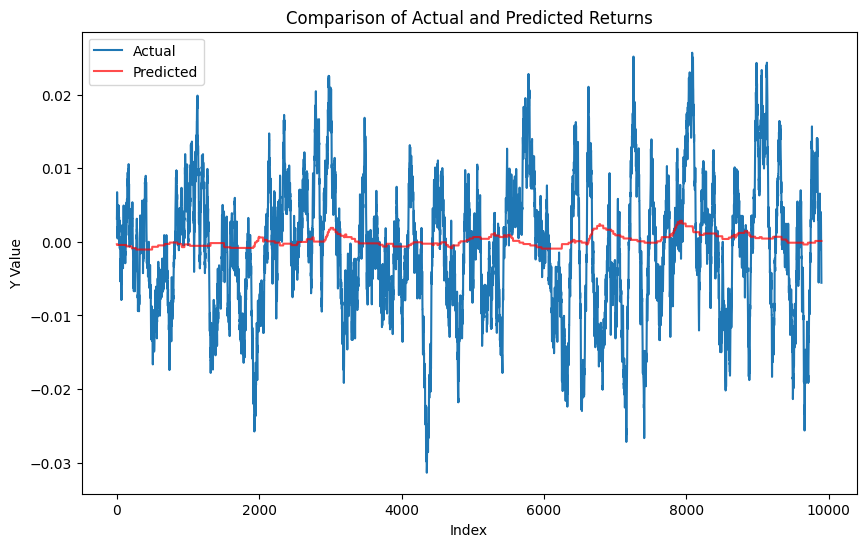

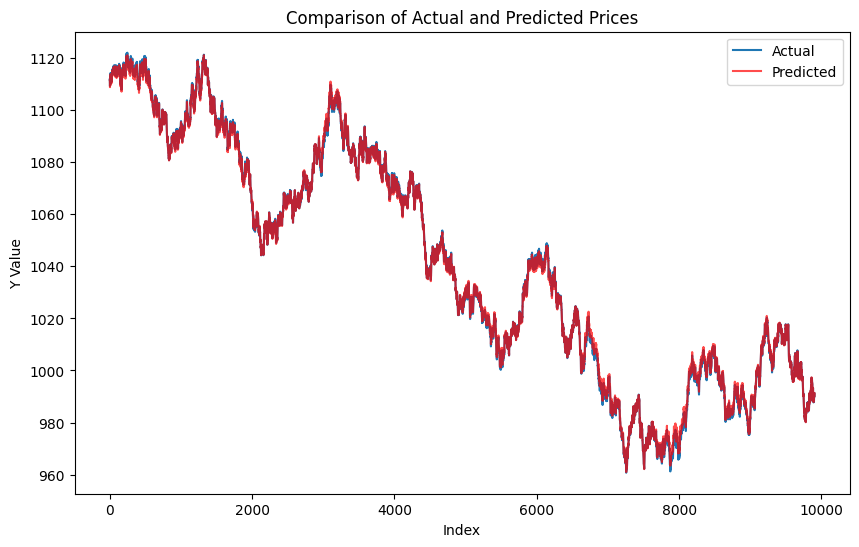

In [24]:
full_prediction(df1, df0)

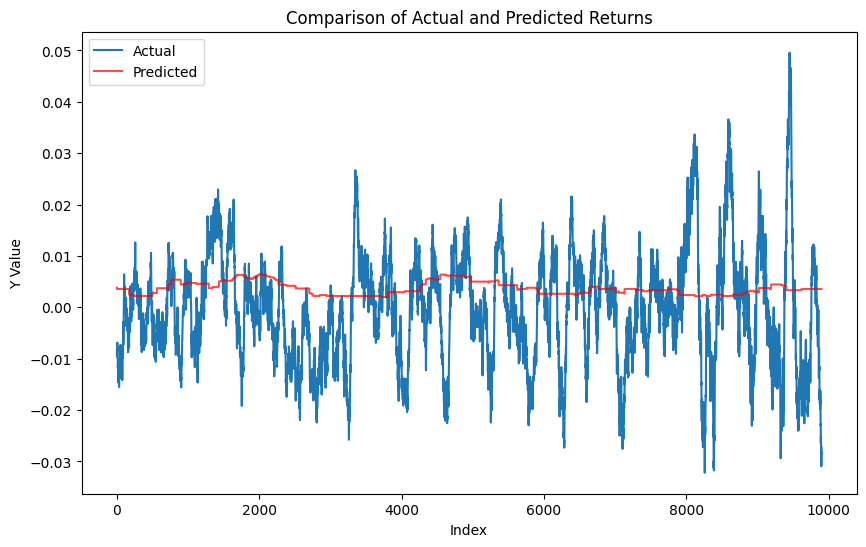

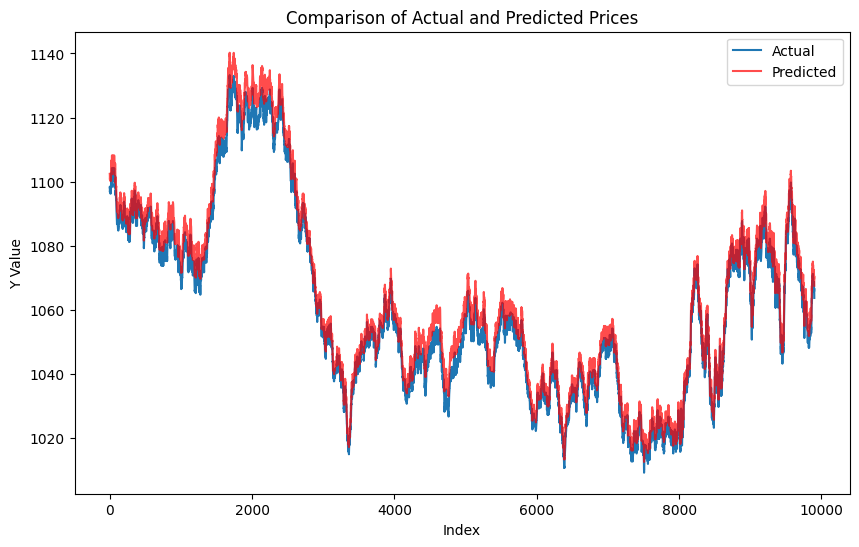

In [25]:
full_prediction(df1, df2)